# Interpretable machine learinig course exercises
## Homeworks shortcuts
* [Home work 1 (Ceteris Paribus plots)](#scrollTo=nO6qQfMklwLz)
* [Home work 2 (Acumulated Local Effects plot)](#scrollTo=aZn9kWe-8mH2)
* [Home work 3](#scrollTo=sz7xTDNqzfTw)

## Model's task
**Find out weather person is merrid**. (*filed S2*)
### Data
From a study [about relationships](https://flowingdata.com/2019/02/26/probability-you-will-break-up-with-your-partner/).
* [Project site and link to data](https://data.stanford.edu/hcmst2017)
* [Columns description](https://stacks.stanford.edu/file/druid:vt073cc9067/HCMST_2017_fresh_Codeboodk_v1.1a.pdf)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(124)

In [4]:
!wget -O - 'http://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip' > HCMST.zip
!unzip HCMST.zip 
!mv 'HCMST 2017 fresh sample for public sharing draft v1.1.dta' HCMST.dta

--2019-03-29 19:02:08--  http://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip
Resolving stacks.stanford.edu (stacks.stanford.edu)... 171.67.37.91
Connecting to stacks.stanford.edu (stacks.stanford.edu)|171.67.37.91|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip [following]
--2019-03-29 19:02:08--  https://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip
Connecting to stacks.stanford.edu (stacks.stanford.edu)|171.67.37.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 463647 (453K) [application/zip]
Saving to: ‘STDOUT’

-                   100%[===================>] 452.78K   804KB/s    in 0.6s    

2019-03-29 19:02:10 (804 KB/s) - written to stdout [463647/463647]

Archive:  HCMST.zip
  inflating: HCMST 2017 fresh sample for public sharing draft v1.1.dta  


In [0]:
raw_data = pd.read_stata('HCMST.dta')

In [6]:
selected_cols = {
    'ppage': 'age', 
    'ppincimp': 'hausehold_income', 
    'ppp20072': 'religion', 
#    'w6_how_many_2': 'different_partners_ly' -- only 2% filedes has not nan value
#    'Q32_2': 'meet_in_internet' -- only 15% data all in not-merried
    'Q25': 'same_high_school'
}
predict_col = {'S1': 'merried'}

data = raw_data[list(selected_cols.keys()) + list(predict_col.keys())]
data = data.rename(selected_cols, axis='columns')
data = data.rename(predict_col, axis='columns')

data.head()

#['partner age','are you same sex','partner education','age', 'Q27: How often do you attend religious services?', 'Did you and [Partner name] attend the same high school?', 'Same university/colage']
#['Q9', 'Q5', 'Q10', 'ppage', 'ppp20072', 'Q25', 'Q26']
# Q23 who earnd more in 2016
# ppgender gendeer

# Q32_2 Did you use an Internet service to meet [Partner name]? 
# w6_how_many_2 byte %8.0g V155_A
#  How many Different people have you met for dating, or romance, or sex in the pas
# w6_q19 byte %8.0g Q19 Are you currently living wit
# Q21A_2_Year Year you first met the partner

,age,hausehold_income,religion,same_high_school,merried
0,30,"$40,000 to $49,999",Never,NaN,"No, I am not Married"
1,55,"$150,000 to $174,999",Never,Different High School,"Yes, I am Married"
2,47,"$200,000 to $249,999",Once or twice a month,Different High School,"Yes, I am Married"
3,28,"$40,000 to $49,999",Never,NaN,"No, I am not Married"
4,59,"$175,000 to $199,999",Once a year or less,Different High School,"Yes, I am Married"


In [0]:
religion_cat = pd.api.types.CategoricalDtype(
    categories=['Never', 'Once a year or less', 'A few times a year',
                'Once or twice a month', 'Once a week', 'More than once a week'],
    ordered=True)

income_cat = pd.api.types.CategoricalDtype(
    categories=['Less than $5,000', '$5,000 to $7,499', '$7,500 to $9,999',
                '$10,000 to $12,499', '$12,500 to $14,999', '$15,000 to $19,999',
                '$20,000 to $24,999', '$25,000 to $29,999', '$30,000 to $34,999',
                '$35,000 to $39,999', '$40,000 to $49,999', '$50,000 to $59,999',
                '$60,000 to $74,999', '$75,000 to $84,999', '$85,000 to $99,999',
                '$100,000 to $124,999', '$125,000 to $149,999', '$150,000 to $174,999',
                '$175,000 to $199,999', '$200,000 to $249,999', '$250,000 or more'],
    ordered=True)

data['age'] = data['age'].astype('int')
#data['hausehold_income'] = data['hausehold_income'].astype(income_cat)
#data['religion'] = data['religion'].astype(religion_cat)

In [0]:
# średnia wartość w przedziale
income_conv = {
    'Less than $5,000': 2.5, 
    '$5,000 to $7,499': 6.25, 
    '$7,500 to $9,999': 8.75,
    '$10,000 to $12,499': 11.25, 
    '$12,500 to $14,999': 13.75, 
    '$15,000 to $19,999': 17.5,
    '$20,000 to $24,999': 22.5, 
    '$25,000 to $29,999': 27.5, 
    '$30,000 to $34,999': 32.5,
    '$35,000 to $39,999': 37.5, 
    '$40,000 to $49,999': 45, 
    '$50,000 to $59,999': 55,
    '$60,000 to $74,999': 67.5, 
    '$75,000 to $84,999': 80, 
    '$85,000 to $99,999': 92.5,
    '$100,000 to $124,999': 112.5, 
    '$125,000 to $149,999': 137.5, 
    '$150,000 to $174,999': 162.5,
    '$175,000 to $199,999': 182.5, 
    '$200,000 to $249,999': 225, 
    '$250,000 or more': 275,       # trudno znaleźć wartość między nieskończonością
}

religion_conv = { religion_cat.categories[i]: i for i in range(len(religion_cat.categories)) }

high_school_conv = { 
    'Same High School': 1, 
    'Different High School': 0,
    np.NaN: 0
}

merried_conv = {
    'No, I am not Married': 0,
    'Yes, I am Married': 1
}


In [9]:
for (name, m) in (('religion', religion_conv), 
                  ('same_high_school', high_school_conv),
                  ('hausehold_income', income_conv),
                  ('merried', merried_conv),):
    data[name + '_val'] = data[name].map(m)

data.head()

,age,hausehold_income,religion,same_high_school,merried,religion_val,same_high_school_val,hausehold_income_val,merried_val
0,30,"$40,000 to $49,999",Never,NaN,"No, I am not Married",0.0,0.0,45.0,0
1,55,"$150,000 to $174,999",Never,Different High School,"Yes, I am Married",0.0,0.0,162.5,1
2,47,"$200,000 to $249,999",Once or twice a month,Different High School,"Yes, I am Married",3.0,0.0,225.0,1
3,28,"$40,000 to $49,999",Never,NaN,"No, I am not Married",0.0,0.0,45.0,0
4,59,"$175,000 to $199,999",Once a year or less,Different High School,"Yes, I am Married",1.0,0.0,182.5,1


In [10]:
use_columns, predict_columns = (['age', 'hausehold_income_val', 'religion_val', 'same_high_school_val'], 'merried_val')

data.dtypes

age                        int64
hausehold_income        category
religion                category
same_high_school        category
merried                 category
religion_val             float64
same_high_school_val     float64
hausehold_income_val     float64
merried_val                int64
dtype: object

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data[use_columns + [predict_columns]].dropna(), test_size=0.2)
test.head()

,age,hausehold_income_val,religion_val,same_high_school_val,merried_val
2236,51,22.5,4.0,0.0,0
369,61,137.5,4.0,0.0,1
1358,56,37.5,5.0,0.0,1
318,57,37.5,2.0,0.0,0
3394,35,112.5,0.0,0.0,1


In [0]:
train_X = train[use_columns]
train_y = train[predict_columns]
test_X = test[use_columns]
test_y = test[predict_columns]

In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_leaf=20)
trained = model.fit(train_X, train_y)

print("Train score: " + str(trained.score(train_X, train_y)))
print("Test score: " + str(trained.score(test_X, test_y)))

Train score: 0.7585059171597633
Test score: 0.7100591715976331


 ## Interpreting the model predictions
 First some instance-level explanations of model decisions.
 We will choose random person from test dataset and analise what determined model decision.

In [23]:
# Wybrana osoba:
persons = [669, 1152, 2236, 130]

data.loc[persons]

,age,hausehold_income,religion,same_high_school,merried,religion_val,same_high_school_val,hausehold_income_val,merried_val
669,22,"$100,000 to $124,999",Once or twice a month,NaN,"No, I am not Married",3.0,0.0,112.5,0
1152,30,"$60,000 to $74,999",Once a week,Different High School,"No, I am not Married",4.0,0.0,67.5,0
2236,51,"$20,000 to $24,999",Once a week,NaN,"No, I am not Married",4.0,0.0,22.5,0
130,75,"$35,000 to $39,999",Once a week,Different High School,"Yes, I am Married",4.0,0.0,37.5,1


## Home work 1
### Ceteris Paribus Profiles *(what-ifs)*
First we will plot the Cetreris Paribus Profiles for given person. That way we will check what would be model prediction if we changed wan input variable and left the rest unchanged.

In [0]:
def predict_with_changed(column, values, instance, model=trained):
    """ Calculates predictions for given instance with changed values of column.
        Uses provided values and 
    """
    spectrum = []
    for i in range(len(values)):
        obj = instance.copy()
        obj[column] = values[i]
        spectrum.append(obj)
    return model.predict_proba(spectrum)

In [0]:
def plot_cpp(column, values, instance, model=trained,title=None, x_values=None, hlines=None):
    # setting default values
    if title is None:
        title = 'Changing column "' + column
        if x_values is None:
            title += '" (' + str(instance[column]) + ')'
        else:
            title += '" (' + str(x_values[int(instance[column])]) + ')'
    if x_values is None:
        x_values = values
    if hlines is None:
        hlines = [0.5]
        
    # getting predictions for changed values
    spectrum  = predict_with_changed(column, values, instance, model)
    real_pred = trained.predict_proba([instance])[0][1]
    real_val  = instance[column]
    
    # plotting results
    plt.ylim(0,1)
    plt.title(title)
    plt.hlines(hlines, values[0], values[-1], '0.5', 'dashed')
    plt.plot(x_values, spectrum[:,1])
    plt.plot(real_val, real_pred, 'ro')
    

In [0]:
def plot_person(index):
    person = data.loc[index]
    parsed_person = data.loc[index].copy()
    parsed_person['pred_merried'] = trained.predict([data.loc[index][use_columns]])[0]
    parsed_person['pred_proba_meried'] = trained.predict_proba([data.loc[index][use_columns]])[0][1]
    
    input_person = parsed_person[use_columns]
    
    plt.figure(figsize=(20,10))
    plt.suptitle('Ceteris Paribus Profiles (' + parsed_person['merried'] + ')', fontsize=18)

    plt.subplot(2, 2, 1)
    plot_cpp('age', range(18, 90), instance=input_person)

    plt.subplot(2, 2, 2)
    plot_cpp('hausehold_income_val', list(income_conv.values()), instance=input_person)

    plt.subplot(2, 2, 3)
    plot_cpp('religion_val', list(religion_conv.values()),x_values=list(religion_conv.keys()), instance=input_person)

    plt.subplot(2, 2, 4)
    hs_spectrum = predict_with_changed('same_high_school_val',[0,1], instance=input_person)
    plt.ylim(0,1)
    plt.title("changing high school (" + str(parsed_person["same_high_school"]) + ")")
    plt.hlines(0.5, -1, 2, '0.5', 'dashed')
    bars = plt.bar(["Different high school or NaN","Same high school"], hs_spectrum[:,1])
    bars[int(input_person["same_high_school_val"])].set_color('r')
    

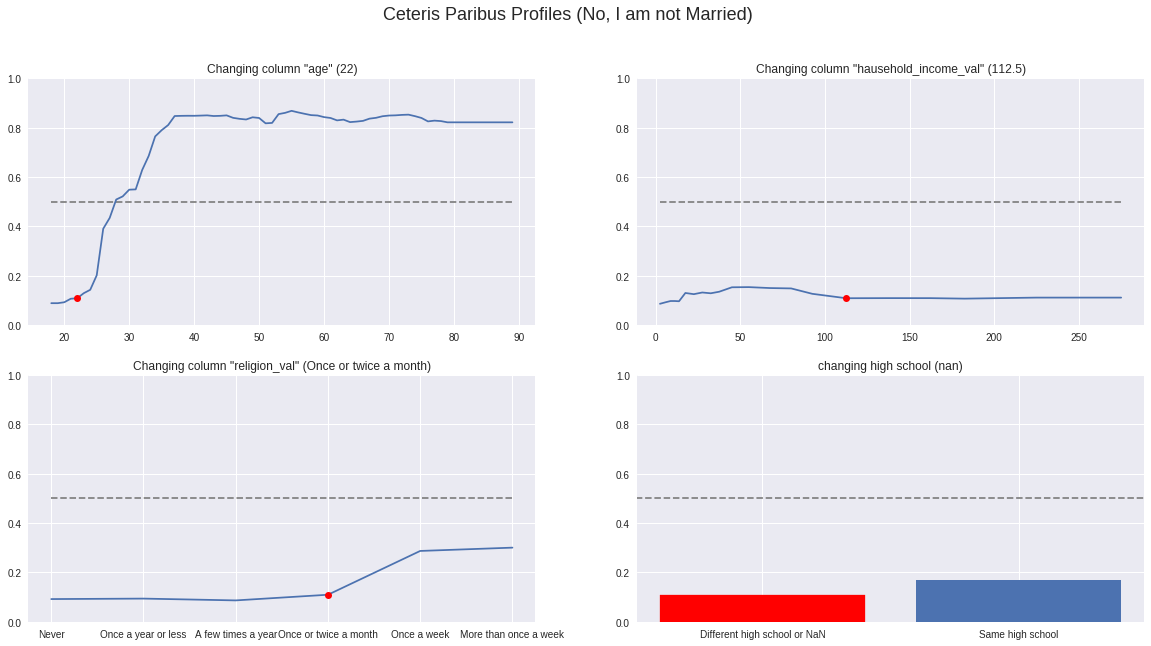

In [0]:
plot_person(persons[0])

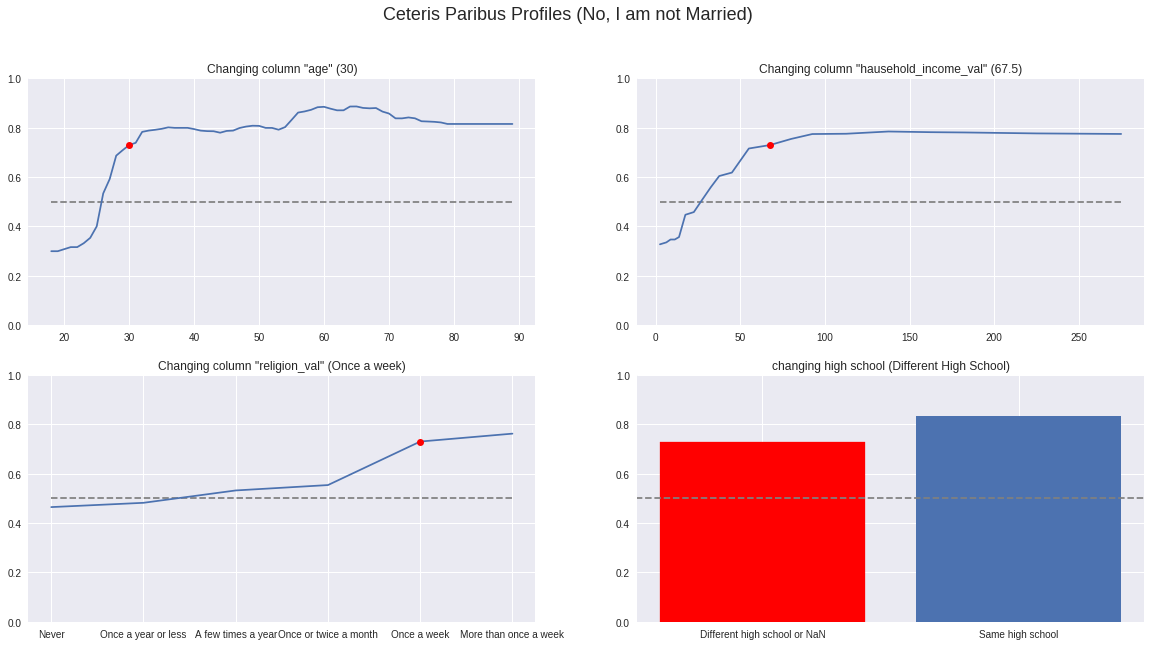

In [0]:
plot_person(persons[1])

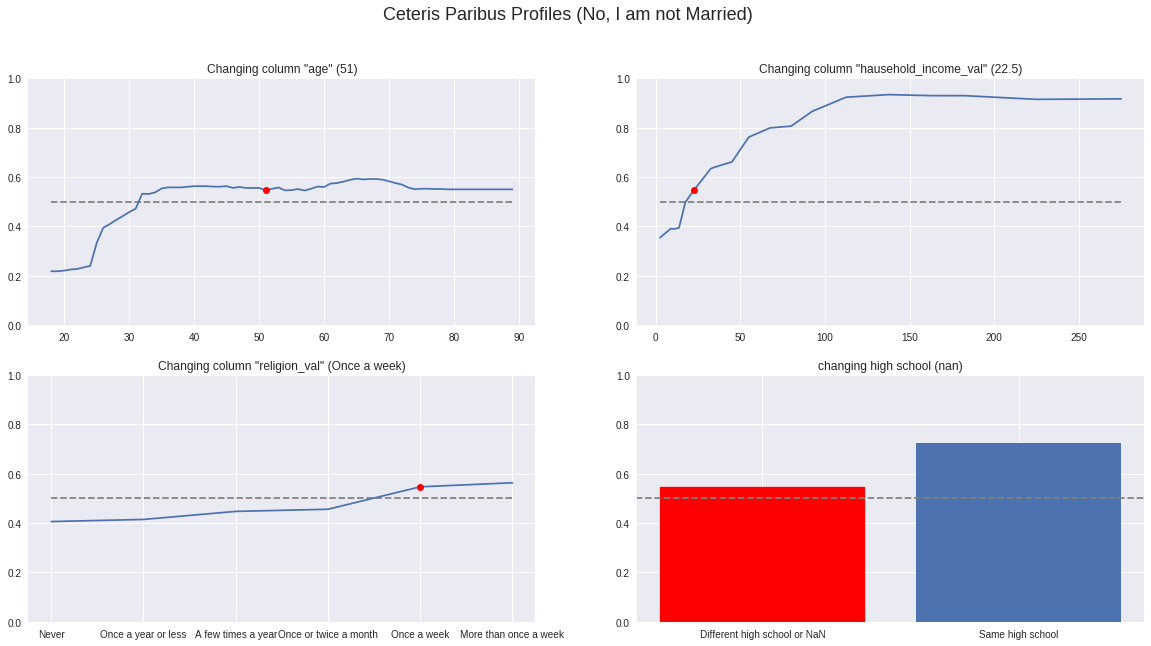

In [0]:
plot_person(persons[2])

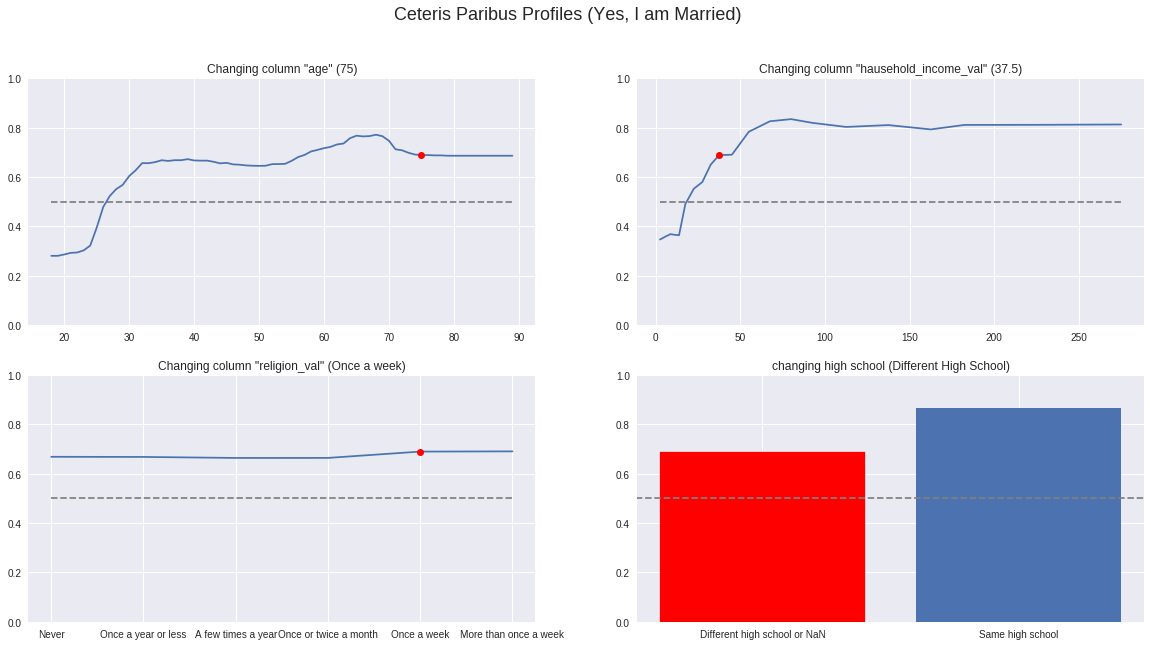

In [0]:
plot_person(persons[3])

## Acumulated Local Effect
### ALE for age

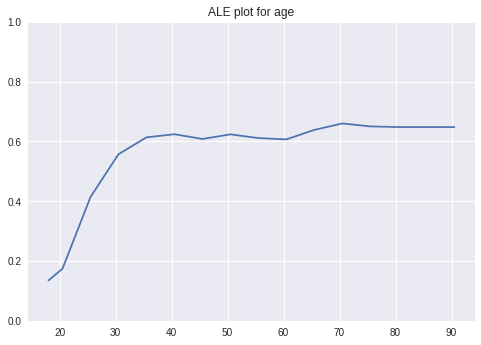

In [0]:
# for age specifing buckets of 5 years
age_bucket_len = 5
age_buckets = range(18,90,age_bucket_len)
ale_x = []
ale_y = []
for bb in age_buckets:
    instances = (test_X[test_X['age'].between(bb, bb + age_bucket_len, inclusive=True)]).copy()#  bb + 5 >= age >= bb 
    instances["age"] = bb
    pred_b = trained.predict_proba(instances)[:,1] # predict instances with changed age to bb
    if len(ale_y) == 0:
        ale_y.append(sum(pred_b) / len(instances))
        ale_x.append(bb)
    instances["age"] = bb + age_bucket_len
    pred_e = trained.predict_proba(instances)[:,1]
    ale = sum(pred_e - pred_b) / len(instances)
    ale_y.append(ale + ale_y[-1])
    ale_x.append(bb + age_bucket_len / 2)
plt.title("ALE plot for age")
plt.ylim(0,1)
plt.plot(ale_x, ale_y)

### ALE for income

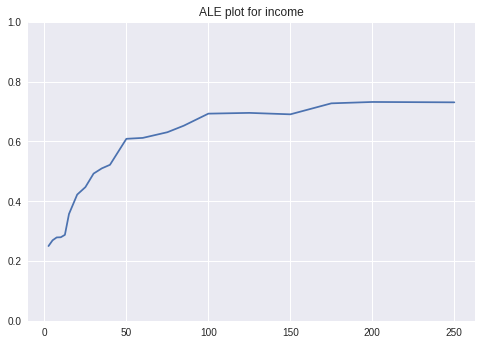

In [0]:
# for income we will use specified categories
i_ale_x = [2.5, 5, 7.5, 10, 12.5, 15, 20, 25, 30, 35, 40, 50, 60, 75, 85, 100, 125, 150, 175, 200, 250]
i_ale_y = []
income_buckets = [2.5, 6.25, 8.75, 11.25, 13.75, 17.5, 22.5, 27.5, 32.5, 37.5, 45, 55, 67.5, 80, 92.5, 112.5, 137.5, 162.5, 182.5, 225, 275]
for i in range(len(income_buckets) - 1):
    bb = income_buckets[i]
    be = income_buckets[i+1]
    instances = (test_X[test_X['hausehold_income_val'].between(bb, be, inclusive=True)]).copy()#  bb + 5 >= age >= bb 
    instances["hausehold_income_val"] = bb
    pred_b = trained.predict_proba(instances)[:,1] # predict instances with changed age to bb
    if len(i_ale_y) == 0:
        i_ale_y.append(sum(pred_b) / len(instances))
    instances["hausehold_income_val"] = be
    pred_e = trained.predict_proba(instances)[:,1]
    ale = sum(pred_e - pred_b) / len(instances)
    i_ale_y.append(ale + i_ale_y[-1])
plt.title("ALE plot for income")
plt.ylim(0,1)
plt.plot(i_ale_x, i_ale_y)

### ALE plotted on Ceteris Paribus profiles

In [0]:
def plot_person_with_ale(index):
    plot_person(index)
    plt.subplot(2, 2, 1)
    plt.plot(ale_x, ale_y, 'g')
    plt.subplot(2, 2, 2)
    plt.plot(i_ale_x, i_ale_y, 'g')
    plt.suptitle('CP with green ALE', fontsize=18)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


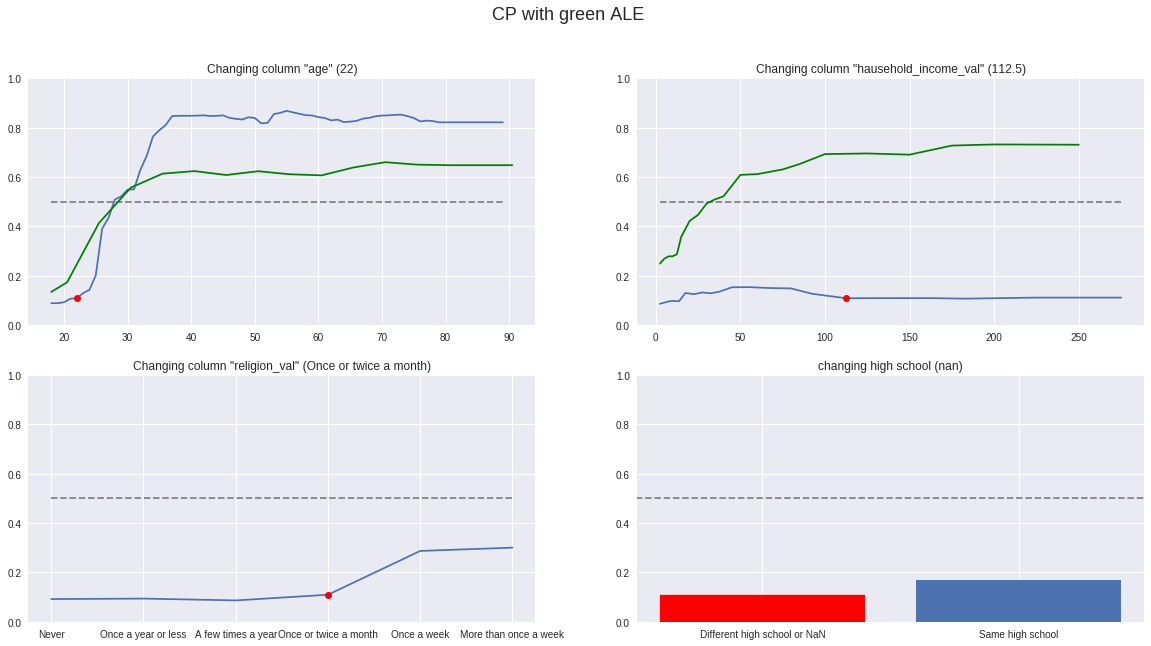

In [0]:
plot_person_with_ale(persons[0])

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


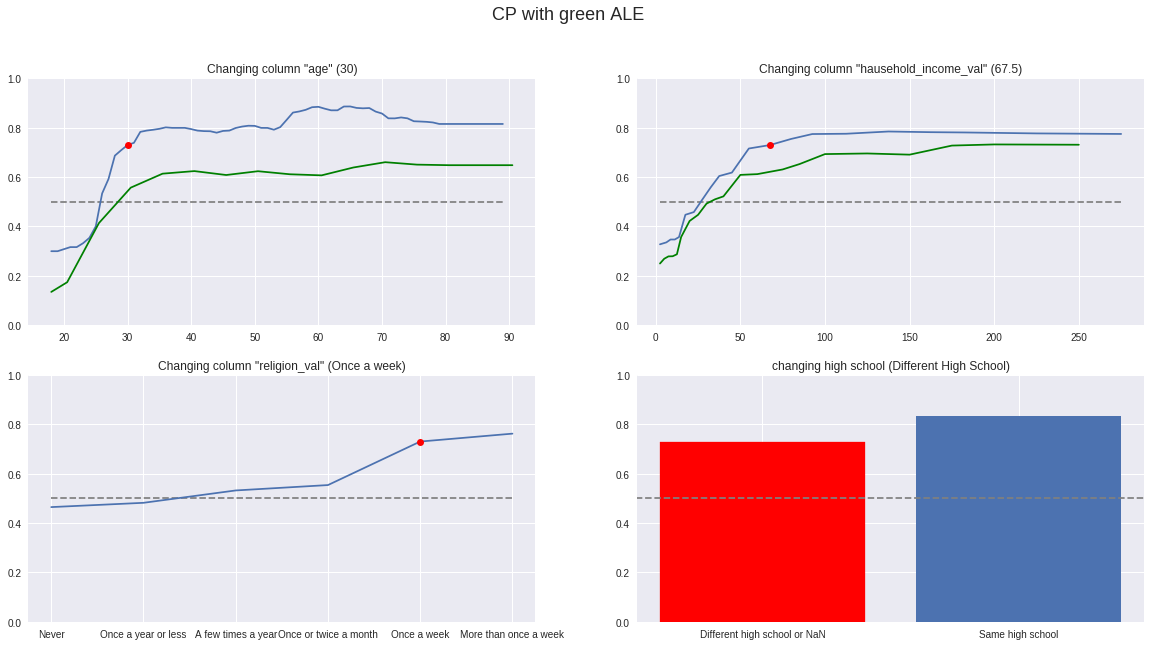

In [0]:
plot_person_with_ale(persons[1])

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


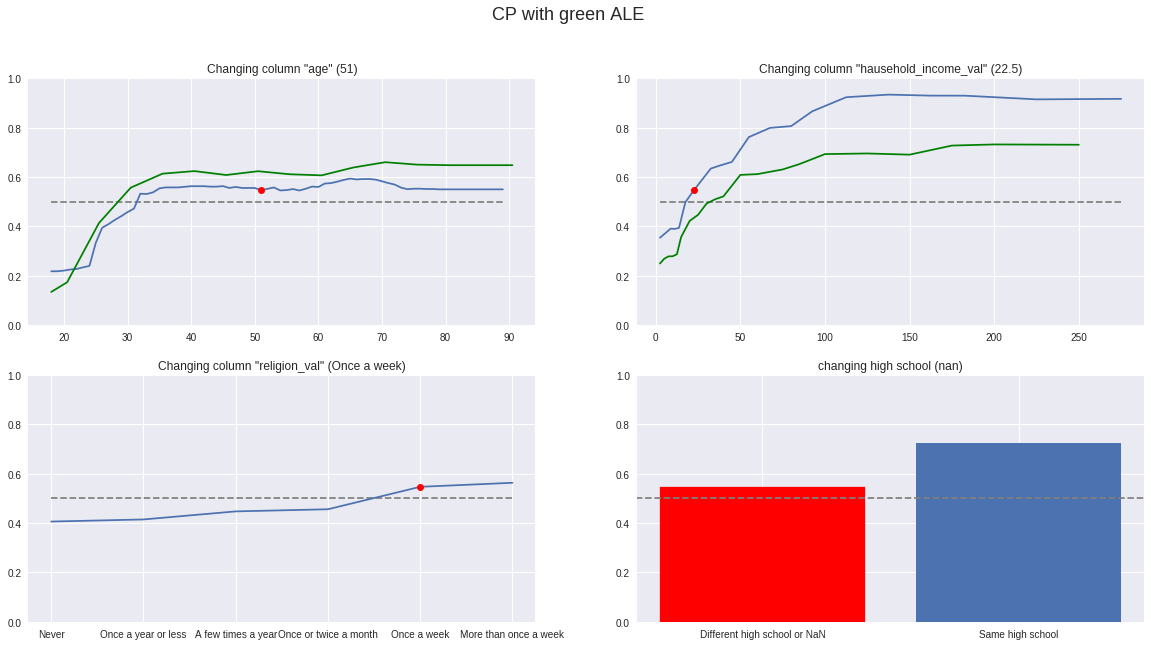

In [0]:
plot_person_with_ale(persons[2])

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


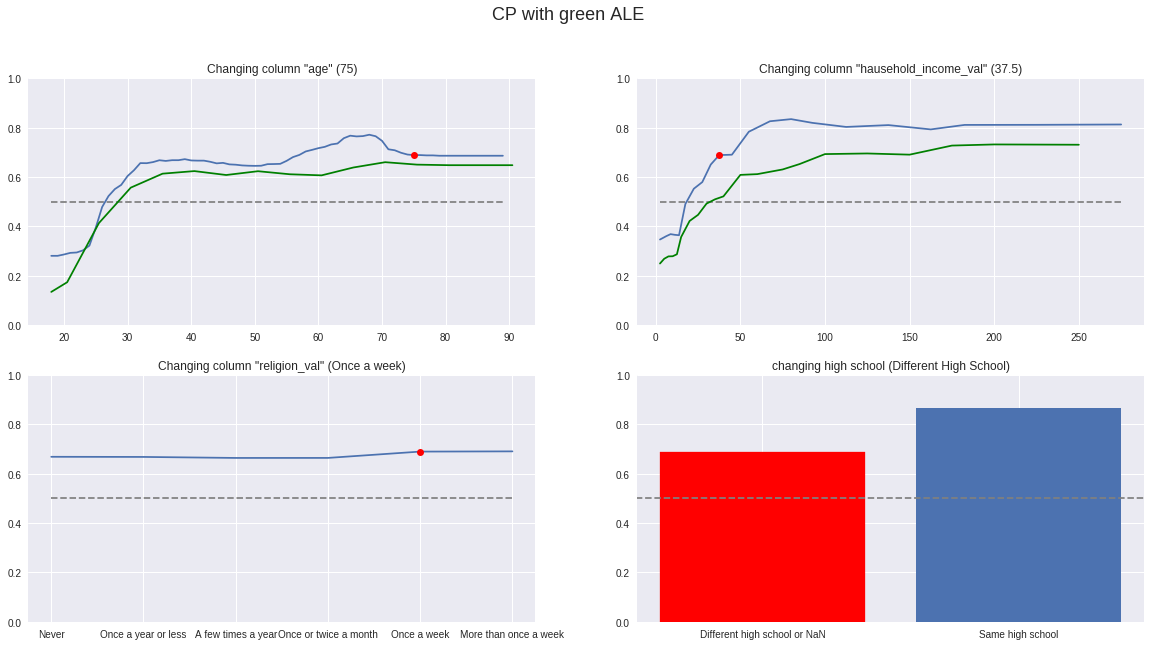

In [0]:
plot_person_with_ale(persons[3])

### Obserwacje
Dla trzech z czterech wybranych osób wykresy Ceteris Paribas i ALE prawie się pokrywają.
Dla wieku są one jedynie delikatnie przeskalowane, a dla dochodu są praktycznie identyczne (przesunięcie w pionie można pominąć ze względu na arbitralne zakotwiczenie wykresu ALE ).

Patrząc na pierwszą osobę, widać, że jej przypadek jest w jakiś sposób szczególny. Wykres wieku jest dużo bardziej rozciągnięty (względem ALE), a wykres związany z dochodem zupełnie zdegenerowany do lini prostej.  Wynika to z pewnością z tego, że jest to jedna z najmłodszych osób w zbiorze danych. Osoby takie często wciąż mieszkają z rodzicami przez co dochód ich gospodarstwa domowego może przyjmować wile wartości. 

### Wnioski
Wydaje się, że generalnie podobny kształt wykresów ALE i CP wskazuje na brak prostej korelacji między wyrysowanymi zmiennymi.

Ze skrajnego przypadku widać natomiast, że istnieją bardziej złożone zależności i warto zwrócić szczególną uwagę na krańcowe wartości (np. bardzo niski wiek), gdyż ogólnie dobre wyjśnienie może dla nich nie działać.

## Comparision of variable impact

In [0]:
def build_up_impact(columns, instance, dataset, model):
    """ Calculates predictions fthe dataset iterativly setting columns values to the instance's one """
    ds = dataset.copy()
    answers = []
    answers.append(model.predict_proba(ds))
    for col in columns:
        ds[col] = instance[col]
        answers.append(model.predict_proba(ds))
    return answers

In [0]:
def get_order_var_impact(columns, instance, dataset, model):
    acc = list(map(lambda proba: np.mean(proba[:,1]),build_up_impact(columns, instance, dataset, model)))
    mean = acc[0]
    impacts = { columns[i]: acc[i + 1] - acc[i] for i in range(len(columns)) }
    return (mean, impacts)

In [0]:
from itertools import permutations
def shapley_impact(columns, instance, dataset, model):
    impacts = { col: 0 for col in columns}
    perms = list(permutations(columns))
    for order in perms:
        _, imp = get_order_var_impact(order, instance, dataset, model)
        for col in columns:
            impacts[col] += imp[col]
    return { k: v / len(perms) for k, v in impacts.items() }

In [0]:
columns_orders = [
    ['age', 'hausehold_income_val', 'religion_val', 'same_high_school_val'],
    ['hausehold_income_val', 'age', 'same_high_school_val', 'religion_val']
]

In [0]:

hatch_map = {'age': '//', 'hausehold_income_val': 'xx', 'religion_val': '++', 'same_high_school_val': 'o'}
short_names = {'age': 'age', 'hausehold_income_val': 'income', 'religion_val': 'religion', 'same_high_school_val': 'same hs'}

In [0]:
def plot_instance(instance, orders, dataset, model):
    n_cols = len(orders[0])
    cols_range = list(range(n_cols))
    global_mean = -1
    plt.figure(figsize=(15,5))
    for i in range(len(orders)):
        plt.subplot(1, len(orders) + 1, i + 1)
        mean, impacts = get_order_var_impact(orders[i], instance, dataset, model)
        global_mean = mean
        bottoms = [mean]
        for col in orders[i][:-1]:
            bottoms.append(bottoms[-1] + impacts[col])
        plt.title('Order ' + str(i + 1) + ' impact')
        plt.ylim(0,1)
        bars = plt.bar(
            x=cols_range,
            height=[float (impacts[col]) for col in orders[i]], 
            bottom=bottoms, 
            color=['red' if impacts[col] < 0 else 'green' for col in orders[i]],
            tick_label=[ short_names[col] for col in orders[i] ]
        )
        for j in cols_range:
            bars[j].set_hatch(hatch_map[orders[i][j]])
    shapley = shapley_impact(orders[0], instance, dataset, model)
    plt.subplot(1, len(orders) + 1, len(orders) + 1)
    plt.title('Average impact')
    plt.ylim(0,1)
    bars = plt.bar(
        x=cols_range,
        height=[float (shapley[col]) for col in orders[0]], 
        bottom=global_mean, 
        color=['red' if impacts[col] < 0 else 'green' for col in orders[0]],
        tick_label=[ short_names[col] for col in orders[0] ]
    )
    for j in cols_range:
        bars[j].set_hatch(hatch_map[orders[0][j]])

def plt_ith_person_impact(i):
    plot_instance(test_X.loc[persons[i]], columns_orders, train_X, trained)
    plt.suptitle('Person ' + str(i + 1), fontsize=18)

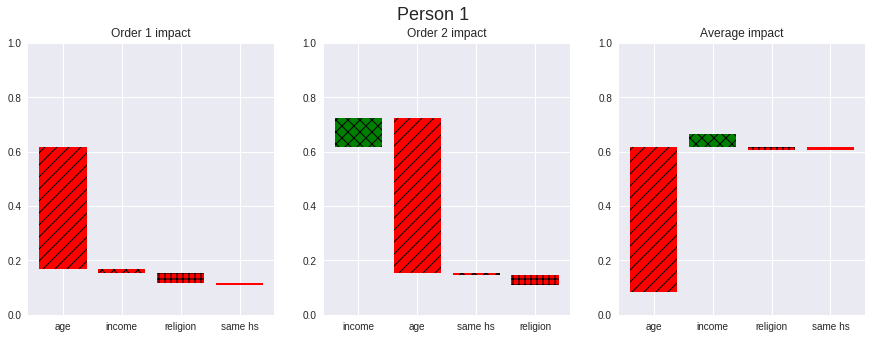

In [114]:
plt_ith_person_impact(0)

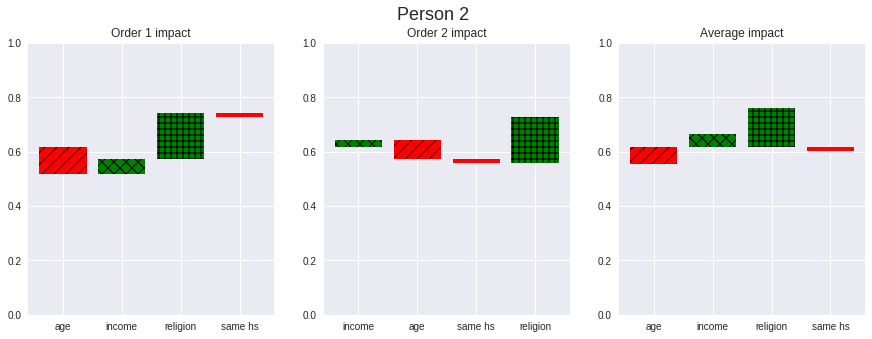

In [115]:
plt_ith_person_impact(1)

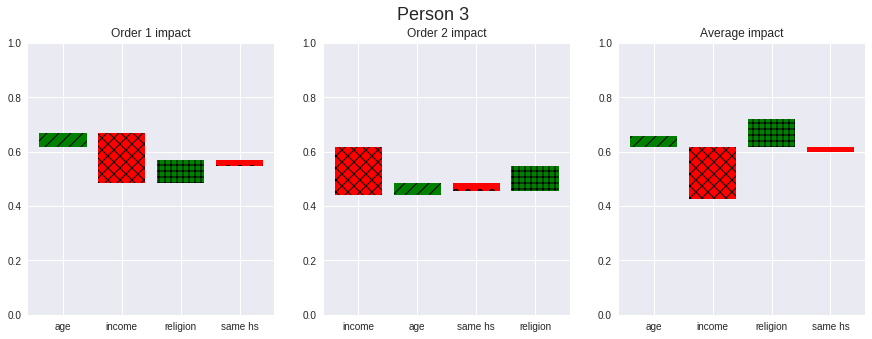

In [116]:
plt_ith_person_impact(2)

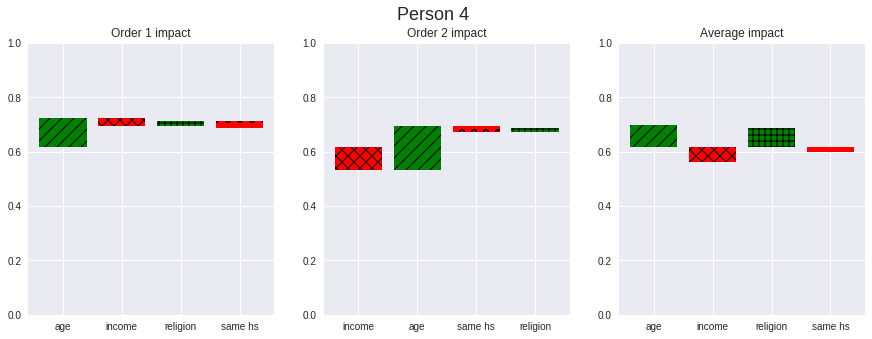

In [117]:
plt_ith_person_impact(3)

### Obserwacje
Widać, że u niektórych osób wyniki dla jednego i drugiego przyporzadkowania mogą się znacząco różnić. Najwyraźniej widać to u osoby 1, gdzie wiek dominuje przewidywanie, a inne zmienne w zasadzie nie mają wartości predykcyjnej, jeśli jednak wiek przesuniemy na drugą pozycję nagle okazuje się, że  dochód ma jakiś wpływ na predykcję.

Można zauważyć też, że zwykle zamienianie kolejnością liceum i religii nie prowadziło do dużych zmian i rzadko też wpływały one na predykcję w znaczący sposób. Widać jednak także, że mogą różnić się one od uśrednionego wpływu, szczególnie religia u osoby 4. Sporo większy słupek w uśrednionym wpływem wskazuje, że istnieje kolejność, w której religia ma niepomijalny wpływ, jednak w tych dwóch kolejnościach nie użyliśmy jej.

W  miarę dobrze widoczne różnice między dwoma wybranymi kolejnościami, a także średnim wpływem podkreślają, że wybranie abitralnej kolejności zmiennych może nie być najlepszym pomysłem.